
========== Hồi quy Bayes cho nồng độ: 250500 (dữ liệu preprocess) ==========
Đang tạo các đặc trưng thời gian...
Đang tạo các đặc trưng độ trễ...
Đang loại bỏ các dòng thiếu dữ liệu...
Đang chuẩn hóa dữ liệu...
Đang huấn luyện mô hình hồi quy Bayes...
Đang dự báo trên tập kiểm tra...
MAE (Sai số tuyệt đối trung bình): 0.175
RMSE (Căn bậc hai sai số bình phương trung bình): 0.234
R2 (Hệ số xác định): 0.923
MAPE (Phần trăm sai số tuyệt đối trung bình): 118.71%


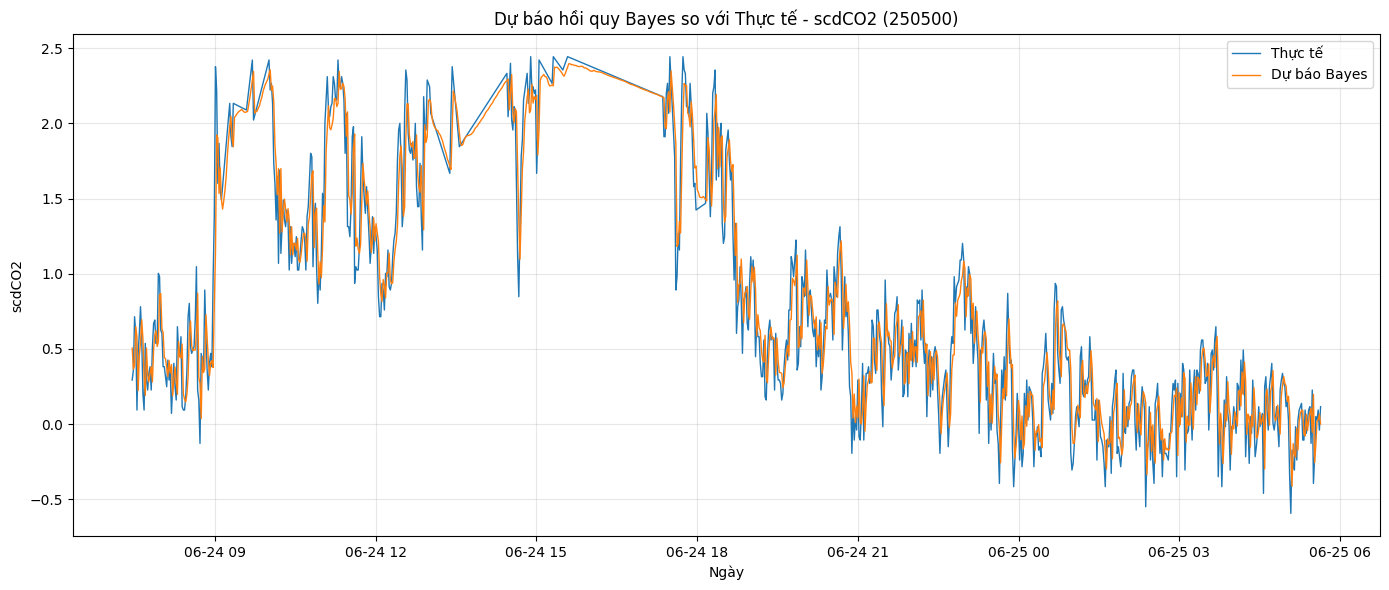


========== Hồi quy Bayes cho nồng độ: 500500 (dữ liệu preprocess) ==========
Đang tạo các đặc trưng thời gian...
Đang tạo các đặc trưng độ trễ...
Đang loại bỏ các dòng thiếu dữ liệu...
Đang chuẩn hóa dữ liệu...
Đang huấn luyện mô hình hồi quy Bayes...
Đang dự báo trên tập kiểm tra...
MAE (Sai số tuyệt đối trung bình): 0.191
RMSE (Căn bậc hai sai số bình phương trung bình): 0.257
R2 (Hệ số xác định): 0.944
MAPE (Phần trăm sai số tuyệt đối trung bình): 873.39%


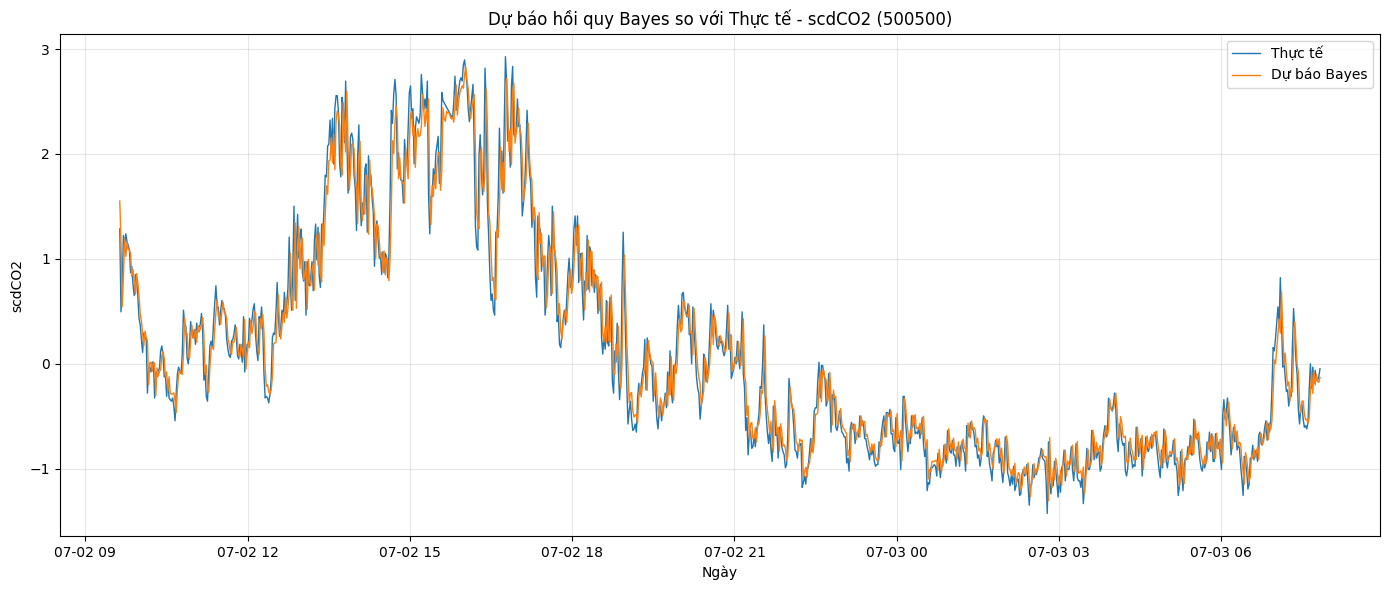


========== Hồi quy Bayes cho nồng độ: 750500 (dữ liệu preprocess) ==========
Đang tạo các đặc trưng thời gian...
Đang tạo các đặc trưng độ trễ...
Đang loại bỏ các dòng thiếu dữ liệu...
Đang chuẩn hóa dữ liệu...
Đang huấn luyện mô hình hồi quy Bayes...
Đang dự báo trên tập kiểm tra...
MAE (Sai số tuyệt đối trung bình): 0.175
RMSE (Căn bậc hai sai số bình phương trung bình): 0.237
R2 (Hệ số xác định): 0.930
MAPE (Phần trăm sai số tuyệt đối trung bình): 128.55%


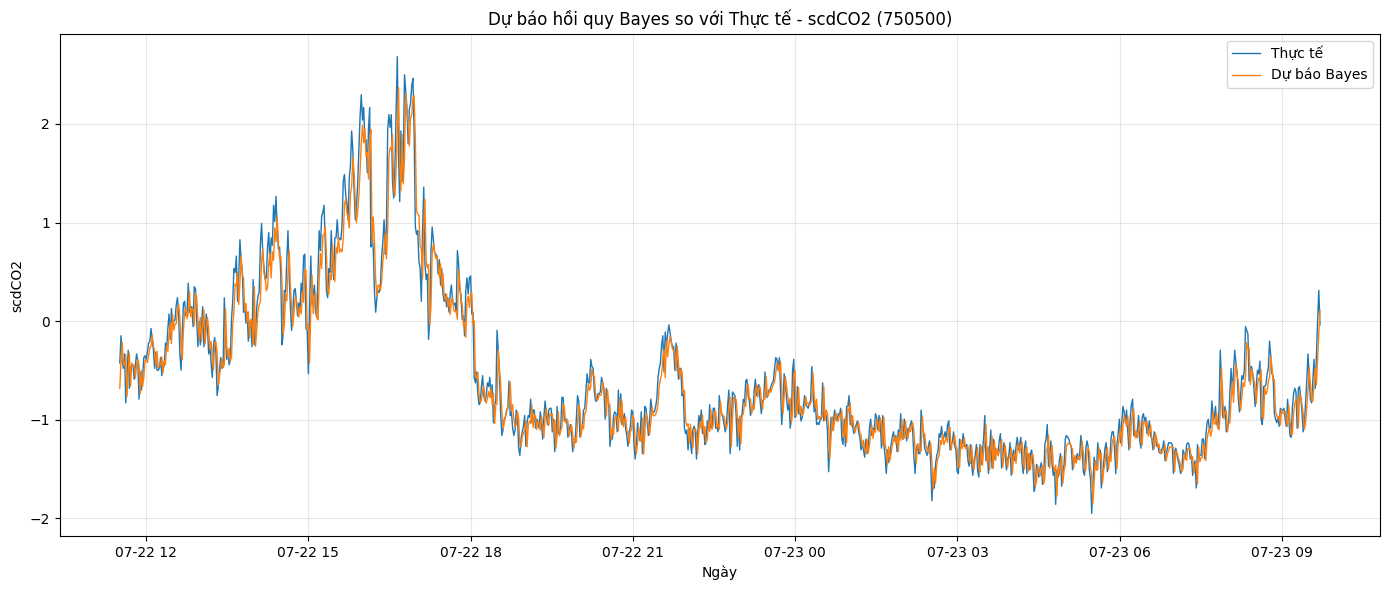


Tổng hợp kết quả các mô hình hồi quy Bayes:
    label       MAE      RMSE        R2        MAPE
0  250500  0.174630  0.234163  0.922507  118.711354
1  500500  0.191061  0.257447  0.944408  873.385514
2  750500  0.174602  0.236778  0.929639  128.552781


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

# Khai báo thư mục và các file dữ liệu
base_dir = r'E:\Khóa luận\Data\Phase 2'
preprocessed_files = {
    '250500': 'preprocessed_250500.csv',
    '500500': 'preprocessed_500500.csv',
    '750500': 'preprocessed_750500.csv'
}

target_col = 'scdCO2'
metrics = []

for label, fname in preprocessed_files.items():
    print(f'\n========== Hồi quy Bayes cho nồng độ: {label} (dữ liệu preprocess) ==========')
    file_path = os.path.join(base_dir, fname)
    data = pd.read_csv(file_path, encoding="utf-8")
    data = data.rename(columns=lambda x: x.strip())
    if 'Date time' in data.columns:
        data['Date time'] = pd.to_datetime(data['Date time'])
        data = data.sort_values('Date time')
        data = data.set_index('Date time')

    # Thêm các đặc trưng thời gian
    print("Đang tạo các đặc trưng thời gian...")
    data['gio'] = data.index.hour
    data['thu'] = data.index.dayofweek
    data['thang'] = data.index.month
    data['ngay'] = data.index.day
    data['tuan'] = data.index.isocalendar().week
    data['cuoi_tuan'] = data['thu'].isin([5, 6]).astype(int)

    # Thêm các đặc trưng độ trễ
    print("Đang tạo các đặc trưng độ trễ...")
    for lag in range(1, 13):
        data[f'{target_col}_lag_{lag}'] = data[target_col].shift(lag)

    # Thêm các đặc trưng môi trường nếu có
    env_features = ['scdTEMP', 'scdHUMID', 'CH4RAWppm']
    env_available = [col for col in env_features if col in data.columns]

    # Danh sách đặc trưng
    time_features = ['gio', 'thu', 'thang', 'ngay', 'tuan', 'cuoi_tuan']
    lag_features = [f'{target_col}_lag_{i}' for i in range(1, 13)]
    feature_list = time_features + lag_features + env_available

    # Loại bỏ các hàng chứa giá trị thiếu
    print("Đang loại bỏ các dòng thiếu dữ liệu...")
    data = data.dropna(subset=feature_list + [target_col])

    # Tách dữ liệu thành tập huấn luyện và kiểm tra (80/20)
    train_size = int(len(data) * 0.8)
    X = data[feature_list]
    y = data[target_col]
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Chuẩn hóa dữ liệu
    print("Đang chuẩn hóa dữ liệu...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Khởi tạo và huấn luyện mô hình hồi quy Bayes
    print("Đang huấn luyện mô hình hồi quy Bayes...")
    bayes_model = BayesianRidge()
    bayes_model.fit(X_train_scaled, y_train)

    # Dự đoán
    print("Đang dự báo trên tập kiểm tra...")
    y_pred = bayes_model.predict(X_test_scaled)

    # Đánh giá mô hình
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + 1e-10))) * 100

    print(f"MAE (Sai số tuyệt đối trung bình): {mae:.3f}")
    print(f"RMSE (Căn bậc hai sai số bình phương trung bình): {rmse:.3f}")
    print(f"R2 (Hệ số xác định): {r2:.3f}")
    print(f"MAPE (Phần trăm sai số tuyệt đối trung bình): {mape:.2f}%")

    # Lưu lại metrics nếu cần tổng hợp sau
    metrics.append({
        'label': label,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    })

    # Vẽ biểu đồ so sánh dự báo và thực tế cho 1000 điểm đầu tiên
    plt.figure(figsize=(14, 6))
    plt.plot(y_test.index[:1000], y_test.values[:1000], label='Thực tế', linewidth=1)
    plt.plot(y_test.index[:1000], y_pred[:1000], label='Dự báo Bayes', linewidth=1)
    plt.title(f'Dự báo hồi quy Bayes so với Thực tế - {target_col} ({label})')
    plt.xlabel('Ngày')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Tổng hợp kết quả các mô hình hồi quy Bayes
metrics_df = pd.DataFrame(metrics)
print("\nTổng hợp kết quả các mô hình hồi quy Bayes:")
print(metrics_df)